In [26]:
import torch
import torchvision
import torchvision.transforms as transforms

In [27]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship',
    'truck'
)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [29]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [30]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7fab4c818eb8>>
Traceback (most recent call last):
  File "/home/admin/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 333, in __del__
    self._shutdown_workers()
  File "/home/admin/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 319, in _shutdown_workers
    self.data_queue.get()
  File "/home/admin/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/admin/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/admin/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn

  car  ship  bird plane


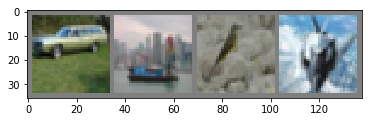

In [31]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a CNN

In [32]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input 3 channels, output 6 channels, 5 x 5 kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 2 x 2 kernel, 2 x 2 stride
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        if not hasattr(self, "flat_x"):
            self.flat_x = self.num_flat_features(x)
            self.fc1 = nn.Linear(self.flat_x, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
        
        x = x.view(-1, self.flat_x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
        
    def num_flat_features(self, x):
        # remove data size
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
net = Net()

In [34]:
import torch.optim as optim

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [36]:
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.302
[1,  4000] loss: 2.296
[1,  6000] loss: 2.285
[1,  8000] loss: 2.265
[1, 10000] loss: 2.243
[1, 12000] loss: 2.211
Finished Training


GroundTruth:    cat  ship  ship plane


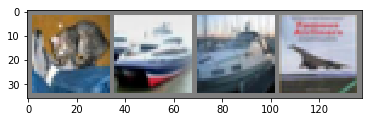

In [37]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [38]:
outputs = net(Variable(images))

In [39]:
_, predicted = torch.max(outputs.data, 1)

In [40]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [41]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 20 %


In [42]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 22 %
Accuracy of   car : 33 %
Accuracy of  bird :  0 %
Accuracy of   cat : 37 %
Accuracy of  deer :  1 %
Accuracy of   dog : 13 %
Accuracy of  frog : 16 %
Accuracy of horse : 10 %
Accuracy of  ship : 67 %
Accuracy of truck :  0 %


AttributeError: 'Net' object has no attribute 'gpu'